In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
DAE_np_data_path = r'data\np\npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:
np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]

In [6]:
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out

In [7]:
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



In [8]:

def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

# plot_integrated_cross_sections(integrated_results)

In [9]:
import math
import torch
import torch.nn as nn

# ---------------------------
# Minimal NPReactionSimulator (batched only)
# ---------------------------
class NPReactionSimulator(nn.Module):
    def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
        super().__init__()
        self.register_buffer("m_n", torch.tensor(float(m_n)))
        self.register_buffer("m_p", torch.tensor(float(m_p)))
        self.register_buffer("M_A", torch.tensor(float(M_A)))
        self.register_buffer("S_n", torch.tensor(float(S_n)))
        self.register_buffer("S_p", torch.tensor(float(S_p)))

    def forward(self, Ek, r1, r2, r3):
        # Ek: (B,) or (B,1) -> expand to (B, N)
        if Ek.dim() == 1:
            Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
        elif Ek.shape[1] == 1:
            Ek = Ek.expand(-1, r1.shape[1])

        m_n, m_p, M_A, S_n, S_p = (
            self.m_n.to(Ek),
            self.m_p.to(Ek),
            self.M_A.to(Ek),
            self.S_n.to(Ek),
            self.S_p.to(Ek)
        )

        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2) * m_n / (denom + 1e-12)
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = r2
        sin_theta_com = torch.sqrt(torch.clamp(1.0 - cos_theta_com**2, min=0.0))
        phi = r3

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        beta = torch.clamp(Tk / (M_recoil + 1e-12), max=0.999999)
        gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-12))

        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)
        p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + 1e-12)

        Ep_lab = torch.where(mask, E_lab - m_p, torch.zeros_like(E_lab))
        cos_theta_lab = torch.where(mask, pz_lab / (p_mag_lab + 1e-12), torch.zeros_like(pz_lab))
        return Ep_lab, cos_theta_lab


# ---------------------------
# Minimal DifferentiableKDE (batched only)
# ---------------------------
class DifferentiableKDE(nn.Module):
    def __init__(self, x_eval, bandwidth=0.6, normalize=True):
        super().__init__()
        self.register_buffer("x_eval", x_eval.view(-1))
        self.bandwidth = float(bandwidth)
        self.normalize = bool(normalize)
        self.register_buffer("sqrt_2pi", torch.tensor(math.sqrt(2 * math.pi), dtype=torch.float32))

    def forward(self, samples, weights=None):
        # samples: (B, N)
        B, N = samples.shape
        M = self.x_eval.numel()

        if weights is None:
            weights = torch.ones_like(samples)

        x = self.x_eval.view(M, 1, 1)
        s = samples.view(1, B, N)

        diffs = (x - s) / self.bandwidth
        kernel_vals = torch.exp(-0.5 * diffs**2) / (self.bandwidth * self.sqrt_2pi)

        w = weights.view(1, B, N)
        density = (kernel_vals * w).sum(dim=2) / (w.sum(dim=2) + 1e-12)

        density = density.permute(1, 0).contiguous()  # (B, M)

        if self.normalize:
            dx = (self.x_eval[1:] - self.x_eval[:-1]).mean().clamp(min=1e-12)
            density /= (density.sum(dim=1, keepdim=True) * dx + 1e-12)

        return density  # (B, M)


# ---------------------------
# Minimal ACSPipeline
# ---------------------------
class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_eval, kde_bandwidth=0.05):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.kde_theta = DifferentiableKDE(cos_theta_eval, bandwidth=kde_bandwidth)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.kde_theta(cos_theta_lab, weights=valid)


In [10]:
# import torch
# import math
# import matplotlib.pyplot as plt
# import numpy as np

# # --- from your data ---
# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
# E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Parameters
# B = len(E_inc_unique)  # one batch per experimental incoming energy
# N = 2000               # MC samples per Ek

# # Expand energies to batch
# Ek_batch = E_inc_unique.to(device)  # shape [B]

# # Random Monte Carlo parameters
# r1 = torch.rand((B, N), device=device)
# r2 = torch.rand((B, N), device=device) * 2 - 1
# r3 = torch.rand((B, N), device=device) * 2 * math.pi - math.pi

# # Create pipeline
# pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# # Run simulation
# with torch.no_grad():
#     dsigma = pipeline(Ek_batch, r1, r2, r3)  # shape [B, M]

# print("dsigma shape:", dsigma.shape)

# # Plot results
# fig, axes = plt.subplots(1, B, figsize=(4 * B, 4), sharey=True)
# if B == 1:
#     axes = [axes]

# for i, ax in enumerate(axes):
#     ax.plot(cos_theta_exp.cpu(), dsigma[i].cpu(), 'b-', lw=2)
#     ax.set_title(f"E_k = {Ek_batch[i].item():.2f} MeV")
#     ax.set_xlabel(r"$\cos\theta$")
#     if i == 0:
#         ax.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (arb. units)")

# plt.tight_layout()
# plt.show()


In [11]:
# # TESTING 
# pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# Ek_batch = torch.tensor([70.0], device=device)  # Example single energy, shape [B]

# r1 = torch.tensor([[0.5]], device=device)
# r1 = torch.tensor([[0.5]], device=device)
# r1 = torch.tensor([[0.5]], device=device)


# # Run simulation
# with torch.no_grad():
#     dsigma = pipeline(Ek_batch, r1, r2, r3)

# dsigma

In [28]:
import torch
import torch.nn.functional as F

def kl_plus_sum_mse_loss(simulated_ddcs, experimental_ddcs, eps=1e-8):
    # --- KL part (shape) ---
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    log_sim = sim_dist.log()
    kl = F.kl_div(log_sim, exp_dist, reduction='batchmean', log_target=False)

    # --- MSE part (scale/height) ---
    mse_sums = F.mse_loss(sim_sum, exp_sum)

    # Combine losses
    loss = kl + 0.00001 * mse_sums

    if torch.isnan(loss):
        print("Loss is NaN")
        print("KL:", kl)
        print("MSE_sums:", mse_sums)

    return loss

def mse_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Mean Squared Error loss for comparing simulated vs experimental cross sections.

    Args:
        pred   : (B, M) Simulated dσ/dΩ values
        target : (B, M) Experimental dσ/dΩ values

    Returns:
        Scalar tensor loss
    """
    return torch.mean((pred - target) ** 2)

# def weighted_mse_loss(pred: torch.Tensor, target: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
#     """
#     Weighted MSE loss, e.g., with weights = 1 / (σ_err^2).
#     """
#     return torch.mean(weights * (pred - target) ** 2)

def hybrid_loss(simulated_ddcs, experimental_ddcs, alpha=0.0001, eps=1e-8):
    # --- KL part (shape) ---
    sim_sum = simulated_ddcs.sum(dim=-1, keepdim=True) + eps
    exp_sum = experimental_ddcs.sum(dim=-1, keepdim=True) + eps

    sim_dist = simulated_ddcs / sim_sum
    exp_dist = experimental_ddcs / exp_sum

    sim_dist = torch.clamp(sim_dist, min=eps)
    exp_dist = torch.clamp(exp_dist, min=eps)

    log_sim = sim_dist.log()
    kl = F.kl_div(log_sim, exp_dist, reduction='batchmean', log_target=False)

    mse_term = torch.mean((simulated_ddcs - experimental_ddcs) ** 2)
    # pred_norm = simulated_ddcs / (simulated_ddcs.sum(dim=1, keepdim=True) + 1e-8)
    # target_norm = experimental_ddcs / (experimental_ddcs.sum(dim=1, keepdim=True) + 1e-8)
    
    # kl_term = torch.sum(target_norm * torch.log((target_norm + 1e-8) / (pred_norm + 1e-8)), dim=1).mean()
    return alpha * mse_term + (1 - alpha) * kl



In [29]:
# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_lamda     = 1       # number of untrainable external parameter dependencies
n_hidden    = 12      # number of hidden neurons in the network, at each layer
n_layers    = 3       # number of hidden layers in the network
n_out       = n_in    # must match the number of output parameters
batch_size  = 64 #2_000   # samples of random number per batch, to build the distribution. Larger is better, but slower
n_mc_samples = 1024
epochs      = 10000   # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer

# ------------------------------------------------------------------
# MLP producing seeds in [0,1]
# ------------------------------------------------------------------
def make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out):
    layers, d = [], n_in + n_lamda
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden), nn.ReLU()]
        d = n_hidden
    layers += [nn.Linear(d, n_out), nn.Sigmoid()]
    return nn.Sequential(*layers)

net       = make_mlp(n_in, n_lamda, n_hidden, n_layers, n_out).to(device)
optimiser = optim.Adam(net.parameters(), lr=lr)
# ------------------------------------------------------------------

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import trange

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------
# Prep
# -------------

E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6
cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# ecs_pipeline = ECSPipeline(E_eval=E_sec_exp).to(device)
acs_pipeline = ACSPipeline(cos_theta_eval=cos_theta_exp).to(device)

# -------------
# Training loop
# -------------

net.train()

all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6  # (N,)
all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, dist_len)

all_Ek = all_Ek.to(device)
all_exp = all_exp.to(device)

num_samples_total = all_Ek.shape[0]

# --- Training loop ---
for epoch in trange(epochs, desc='Training Epochs'):
    # Sample random indices for batch
    idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

    Ek_batch = all_Ek[idx]  # (B,)
    dsigma_dOmega_exp = all_exp[idx]  # (B, M)

    # Draw random uniform inputs for network
    # Shape: (B, N, n_in)
    uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

    # Append Ek to each MC sample row
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples).unsqueeze(-1)  # (B, N, 1)
    net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)  # (B, N, n_in+1)

    # Flatten for network: (B*N, n_in+1)
    net_input_flat = net_input.reshape(-1, n_in + 1)

    # Predict r1, r2, r3 in flat form then reshape
    t = net(net_input_flat).reshape(batch_size, n_mc_samples, 3)
    r1 = t[:, :, 0]
    r2 = t[:, :, 1] * 2 - 1
    r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

    # Run simulation
    dsigma_dOmega_sim = acs_pipeline(Ek_batch, r1, r2, r3)  # (B, M)

    # Compute loss
    # loss = kl_plus_sum_mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)
    # loss = mse_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)

    loss = hybrid_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.6f}")


Training Epochs:   0%|          | 3/10000 [00:00<06:11, 26.90it/s]

Epoch   1 | Loss: 17.077732


Training Epochs:   1%|          | 106/10000 [00:03<04:15, 38.66it/s]

Epoch 101 | Loss: 17.053852


Training Epochs:   2%|▏         | 209/10000 [00:05<04:00, 40.70it/s]

Epoch 201 | Loss: 17.106798


Training Epochs:   3%|▎         | 308/10000 [00:08<04:14, 38.10it/s]

Epoch 301 | Loss: 17.024706


Training Epochs:   4%|▍         | 408/10000 [00:10<03:57, 40.38it/s]

Epoch 401 | Loss: 17.107639


Training Epochs:   5%|▌         | 507/10000 [00:13<03:52, 40.75it/s]

Epoch 501 | Loss: 17.073227


Training Epochs:   6%|▌         | 606/10000 [00:15<04:01, 38.90it/s]

Epoch 601 | Loss: 17.149734


Training Epochs:   7%|▋         | 706/10000 [00:18<03:44, 41.32it/s]

Epoch 701 | Loss: 17.041353


Training Epochs:   8%|▊         | 807/10000 [00:20<03:47, 40.36it/s]

Epoch 801 | Loss: 17.070539


Training Epochs:   9%|▉         | 906/10000 [00:23<03:52, 39.05it/s]

Epoch 901 | Loss: 17.103764


Training Epochs:  10%|█         | 1005/10000 [00:25<03:33, 42.03it/s]

Epoch 1001 | Loss: 17.078787


Training Epochs:  11%|█         | 1106/10000 [00:28<03:41, 40.07it/s]

Epoch 1101 | Loss: 17.075672


Training Epochs:  12%|█▏        | 1209/10000 [00:31<03:32, 41.33it/s]

Epoch 1201 | Loss: 17.080725


Training Epochs:  13%|█▎        | 1309/10000 [00:34<03:26, 42.10it/s]

Epoch 1301 | Loss: 17.104742


Training Epochs:  14%|█▍        | 1409/10000 [00:36<03:21, 42.57it/s]

Epoch 1401 | Loss: 17.099346


Training Epochs:  15%|█▌        | 1507/10000 [00:38<03:13, 43.91it/s]

Epoch 1501 | Loss: 17.128977


Training Epochs:  16%|█▌        | 1607/10000 [00:41<03:07, 44.83it/s]

Epoch 1601 | Loss: 17.079302


Training Epochs:  17%|█▋        | 1707/10000 [00:43<03:07, 44.34it/s]

Epoch 1701 | Loss: 17.085808


Training Epochs:  18%|█▊        | 1807/10000 [00:45<03:03, 44.72it/s]

Epoch 1801 | Loss: 17.090811


Training Epochs:  19%|█▉        | 1907/10000 [00:48<03:09, 42.81it/s]

Epoch 1901 | Loss: 17.128660


Training Epochs:  20%|██        | 2007/10000 [00:50<03:09, 42.19it/s]

Epoch 2001 | Loss: 16.989540


Training Epochs:  21%|██        | 2107/10000 [00:53<03:03, 43.04it/s]

Epoch 2101 | Loss: 17.100636


Training Epochs:  22%|██▏       | 2207/10000 [00:55<02:53, 44.82it/s]

Epoch 2201 | Loss: 17.089645


Training Epochs:  23%|██▎       | 2307/10000 [00:57<02:58, 43.19it/s]

Epoch 2301 | Loss: 17.054512


Training Epochs:  24%|██▍       | 2406/10000 [01:00<02:55, 43.17it/s]

Epoch 2401 | Loss: 17.031832


Training Epochs:  25%|██▌       | 2509/10000 [01:02<03:05, 40.30it/s]

Epoch 2501 | Loss: 17.104275


Training Epochs:  26%|██▌       | 2608/10000 [01:05<02:50, 43.33it/s]

Epoch 2601 | Loss: 17.108166


Training Epochs:  27%|██▋       | 2708/10000 [01:07<02:46, 43.80it/s]

Epoch 2701 | Loss: 17.070593


Training Epochs:  28%|██▊       | 2807/10000 [01:09<02:37, 45.53it/s]

Epoch 2801 | Loss: 17.119274


Training Epochs:  29%|██▉       | 2907/10000 [01:12<02:43, 43.38it/s]

Epoch 2901 | Loss: 17.034439


Training Epochs:  30%|███       | 3007/10000 [01:14<02:35, 44.89it/s]

Epoch 3001 | Loss: 17.109812


Training Epochs:  31%|███       | 3107/10000 [01:16<02:35, 44.27it/s]

Epoch 3101 | Loss: 17.113829


Training Epochs:  32%|███▏      | 3207/10000 [01:19<02:37, 43.10it/s]

Epoch 3201 | Loss: 17.032692


Training Epochs:  33%|███▎      | 3306/10000 [01:21<02:33, 43.52it/s]

Epoch 3301 | Loss: 17.137957


Training Epochs:  34%|███▍      | 3408/10000 [01:24<02:52, 38.26it/s]

Epoch 3401 | Loss: 17.122416


Training Epochs:  35%|███▌      | 3506/10000 [01:26<02:55, 37.10it/s]

Epoch 3501 | Loss: 17.059036


Training Epochs:  36%|███▌      | 3606/10000 [01:29<03:02, 35.08it/s]

Epoch 3601 | Loss: 17.051315


Training Epochs:  37%|███▋      | 3706/10000 [01:32<02:40, 39.27it/s]

Epoch 3701 | Loss: 17.091614


Training Epochs:  38%|███▊      | 3808/10000 [01:34<02:39, 38.93it/s]

Epoch 3801 | Loss: 17.105528


Training Epochs:  39%|███▉      | 3908/10000 [01:37<02:30, 40.42it/s]

Epoch 3901 | Loss: 17.069530


Training Epochs:  40%|████      | 4006/10000 [01:40<02:41, 37.09it/s]

Epoch 4001 | Loss: 17.070688


Training Epochs:  41%|████      | 4104/10000 [01:42<02:43, 36.08it/s]

Epoch 4101 | Loss: 17.036674


Training Epochs:  42%|████▏     | 4209/10000 [01:45<02:24, 40.02it/s]

Epoch 4201 | Loss: 17.035351


Training Epochs:  43%|████▎     | 4305/10000 [01:48<02:25, 39.10it/s]

Epoch 4301 | Loss: 17.079565


Training Epochs:  44%|████▍     | 4409/10000 [01:50<02:05, 44.39it/s]

Epoch 4401 | Loss: 17.118242


Training Epochs:  45%|████▌     | 4509/10000 [01:53<02:02, 44.68it/s]

Epoch 4501 | Loss: 17.107359


Training Epochs:  46%|████▌     | 4609/10000 [01:55<02:01, 44.25it/s]

Epoch 4601 | Loss: 17.063864


Training Epochs:  47%|████▋     | 4709/10000 [01:57<02:00, 43.74it/s]

Epoch 4701 | Loss: 17.106745


Training Epochs:  48%|████▊     | 4804/10000 [02:00<02:22, 36.46it/s]

Epoch 4801 | Loss: 17.095024


Training Epochs:  49%|████▉     | 4908/10000 [02:02<01:58, 43.05it/s]

Epoch 4901 | Loss: 17.033768


Training Epochs:  50%|█████     | 5006/10000 [02:04<01:49, 45.57it/s]

Epoch 5001 | Loss: 17.076096


Training Epochs:  51%|█████     | 5107/10000 [02:07<02:14, 36.27it/s]

Epoch 5101 | Loss: 17.140793


Training Epochs:  52%|█████▏    | 5210/10000 [02:09<01:47, 44.72it/s]

Epoch 5201 | Loss: 17.134293


Training Epochs:  53%|█████▎    | 5305/10000 [02:12<01:44, 44.83it/s]

Epoch 5301 | Loss: 17.030167


Training Epochs:  54%|█████▍    | 5410/10000 [02:14<01:44, 44.02it/s]

Epoch 5401 | Loss: 17.043968


Training Epochs:  55%|█████▌    | 5510/10000 [02:16<01:39, 45.04it/s]

Epoch 5501 | Loss: 17.067274


Training Epochs:  56%|█████▌    | 5610/10000 [02:19<01:39, 44.12it/s]

Epoch 5601 | Loss: 17.017929


Training Epochs:  57%|█████▋    | 5709/10000 [02:21<01:34, 45.27it/s]

Epoch 5701 | Loss: 17.056980


Training Epochs:  58%|█████▊    | 5805/10000 [02:23<01:41, 41.49it/s]

Epoch 5801 | Loss: 17.097778


Training Epochs:  59%|█████▉    | 5906/10000 [02:26<01:45, 38.92it/s]

Epoch 5901 | Loss: 17.065077


Training Epochs:  60%|██████    | 6004/10000 [02:28<01:48, 36.89it/s]

Epoch 6001 | Loss: 17.092920


Training Epochs:  61%|██████    | 6106/10000 [02:31<01:27, 44.35it/s]

Epoch 6101 | Loss: 17.050373


Training Epochs:  62%|██████▏   | 6206/10000 [02:33<01:28, 42.86it/s]

Epoch 6201 | Loss: 17.064976


Training Epochs:  63%|██████▎   | 6305/10000 [02:36<01:30, 40.77it/s]

Epoch 6301 | Loss: 17.068890


Training Epochs:  64%|██████▍   | 6410/10000 [02:38<01:21, 44.23it/s]

Epoch 6401 | Loss: 17.095633


Training Epochs:  65%|██████▌   | 6510/10000 [02:40<01:17, 44.84it/s]

Epoch 6501 | Loss: 17.112143


Training Epochs:  66%|██████▌   | 6607/10000 [02:43<01:30, 37.60it/s]

Epoch 6601 | Loss: 17.092146


Training Epochs:  67%|██████▋   | 6706/10000 [02:45<01:22, 39.88it/s]

Epoch 6701 | Loss: 17.046877


Training Epochs:  68%|██████▊   | 6808/10000 [02:48<01:23, 38.32it/s]

Epoch 6801 | Loss: 17.108194


Training Epochs:  69%|██████▉   | 6906/10000 [02:50<01:09, 44.82it/s]

Epoch 6901 | Loss: 17.077410


Training Epochs:  70%|███████   | 7007/10000 [02:53<01:02, 47.68it/s]

Epoch 7001 | Loss: 17.075138


Training Epochs:  71%|███████   | 7107/10000 [02:55<01:05, 44.27it/s]

Epoch 7101 | Loss: 17.066875


Training Epochs:  72%|███████▏  | 7207/10000 [02:57<01:01, 45.05it/s]

Epoch 7201 | Loss: 17.033533


Training Epochs:  73%|███████▎  | 7307/10000 [02:59<01:01, 43.78it/s]

Epoch 7301 | Loss: 17.154013


Training Epochs:  74%|███████▍  | 7407/10000 [03:02<00:58, 44.02it/s]

Epoch 7401 | Loss: 17.057705


Training Epochs:  75%|███████▌  | 7507/10000 [03:04<00:56, 43.92it/s]

Epoch 7501 | Loss: 17.070230


Training Epochs:  76%|███████▌  | 7607/10000 [03:06<00:53, 44.63it/s]

Epoch 7601 | Loss: 17.092035


Training Epochs:  77%|███████▋  | 7707/10000 [03:09<00:49, 46.29it/s]

Epoch 7701 | Loss: 17.077593


Training Epochs:  78%|███████▊  | 7807/10000 [03:11<00:49, 44.50it/s]

Epoch 7801 | Loss: 17.058594


Training Epochs:  79%|███████▉  | 7907/10000 [03:13<00:46, 45.45it/s]

Epoch 7901 | Loss: 17.121208


Training Epochs:  80%|████████  | 8007/10000 [03:16<00:45, 43.81it/s]

Epoch 8001 | Loss: 17.072657


Training Epochs:  81%|████████  | 8107/10000 [03:18<00:41, 45.89it/s]

Epoch 8101 | Loss: 17.045788


Training Epochs:  82%|████████▏ | 8207/10000 [03:20<00:40, 44.14it/s]

Epoch 8201 | Loss: 17.054737


Training Epochs:  83%|████████▎ | 8307/10000 [03:22<00:38, 44.47it/s]

Epoch 8301 | Loss: 17.109468


Training Epochs:  84%|████████▍ | 8407/10000 [03:25<00:34, 46.06it/s]

Epoch 8401 | Loss: 17.133715


Training Epochs:  85%|████████▌ | 8507/10000 [03:27<00:33, 44.14it/s]

Epoch 8501 | Loss: 17.059595


Training Epochs:  86%|████████▌ | 8609/10000 [03:29<00:31, 44.56it/s]

Epoch 8601 | Loss: 17.084249


Training Epochs:  87%|████████▋ | 8709/10000 [03:32<00:29, 43.53it/s]

Epoch 8701 | Loss: 17.109974


Training Epochs:  88%|████████▊ | 8809/10000 [03:34<00:26, 44.62it/s]

Epoch 8801 | Loss: 17.101061


Training Epochs:  89%|████████▉ | 8909/10000 [03:36<00:23, 46.52it/s]

Epoch 8901 | Loss: 17.123569


Training Epochs:  90%|█████████ | 9009/10000 [03:39<00:22, 43.26it/s]

Epoch 9001 | Loss: 17.098291


Training Epochs:  91%|█████████ | 9109/10000 [03:41<00:19, 45.71it/s]

Epoch 9101 | Loss: 17.123610


Training Epochs:  92%|█████████▏| 9209/10000 [03:43<00:18, 43.84it/s]

Epoch 9201 | Loss: 17.074081


Training Epochs:  93%|█████████▎| 9309/10000 [03:45<00:15, 44.97it/s]

Epoch 9301 | Loss: 17.009241


Training Epochs:  94%|█████████▍| 9404/10000 [03:48<00:14, 41.97it/s]

Epoch 9401 | Loss: 17.077789


Training Epochs:  95%|█████████▌| 9508/10000 [03:50<00:11, 44.46it/s]

Epoch 9501 | Loss: 17.137430


Training Epochs:  96%|█████████▌| 9608/10000 [03:53<00:08, 46.27it/s]

Epoch 9601 | Loss: 17.108551


Training Epochs:  97%|█████████▋| 9708/10000 [03:55<00:06, 43.42it/s]

Epoch 9701 | Loss: 17.038254


Training Epochs:  98%|█████████▊| 9807/10000 [03:57<00:04, 44.21it/s]

Epoch 9801 | Loss: 17.113047


Training Epochs:  99%|█████████▉| 9907/10000 [04:00<00:02, 45.29it/s]

Epoch 9901 | Loss: 17.089039


Training Epochs: 100%|██████████| 10000/10000 [04:02<00:00, 41.24it/s]


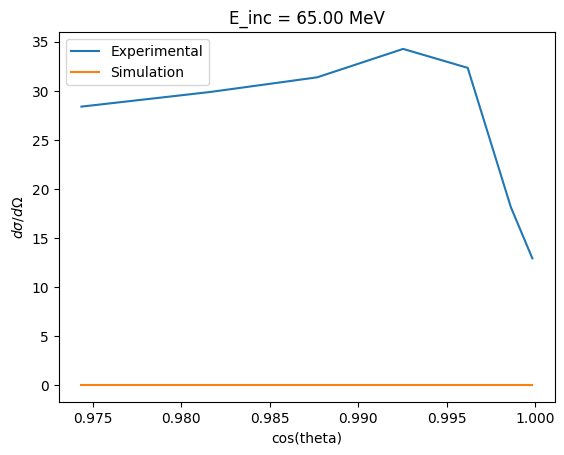

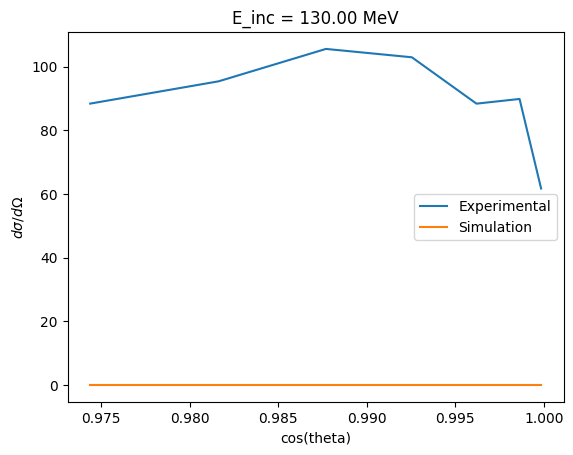

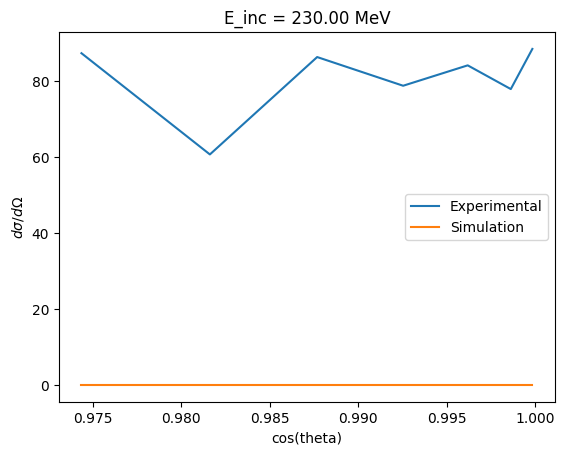

In [31]:
import torch
import matplotlib.pyplot as plt

net.eval()

n_mc_samples = 2000
monitor_indices = [0, len(integrated_results) // 2, -1]  # pick a few energies

for idx in monitor_indices:
    # Experimental values
    Ek_val = integrated_results[idx]['E_inc'] / 1e6  # scalar tensor
    exp_dist = integrated_results[idx]['int_over_E_sec'].to(device)  # (M,)

    # Shape (B=1, N) for Monte Carlo
    Ek_batch = Ek_val.unsqueeze(0).to(device)  # (1,)
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples)  # (1, N)

    # Random latent samples: (B=1, N, n_in)
    uniform_samples = torch.rand((1, n_mc_samples, n_in), device=device)

    # Append Ek to each MC sample row: (1, N, n_in+1)
    net_input = torch.cat([uniform_samples, Ek_expanded.unsqueeze(-1)], dim=-1)

    # Flatten for net: (B*N, n_in+1)
    net_input_flat = net_input.reshape(-1, n_in + 1)

    with torch.no_grad():
        t = net(net_input_flat).reshape(1, n_mc_samples, 3)
        r1 = t[:, :, 0]
        r2 = t[:, :, 1] * 2 - 1
        r3 = t[:, :, 2] * 2 * torch.pi - torch.pi

        # Now acs_pipeline gets (B=1, N) inputs for r1, r2, r3
        sim_dist = acs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)

    # Plot
    plt.figure()
    plt.plot(cos_theta_exp.cpu(), exp_dist.cpu(), label='Experimental')
    plt.plot(cos_theta_exp.cpu(), sim_dist.cpu(), label='Simulation')
    plt.xlabel('cos(theta)')
    plt.ylabel(r'$d\sigma/d\Omega$')
    plt.title(f'E_inc = {Ek_val.item():.2f} MeV')
    plt.legend()
    plt.show()
